In [4]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.stats import bernoulli
from scipy.special import expit as sigmoid

from sklearn.datasets import make_moons
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import ConstantKernel
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import Matern

from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sys, os
from design_space import sample_design_space
%matplotlib inline

## Load Data
We need to load the volumes of the samples and the classification of these samples (if they are plates or not). This classification will come from the notebook: Shape Exploration - Phase Mapping. 

In [5]:
def load_data(path):
    volumes = pd.read_csv(path).values
    PVP = (volumes[:,0]*2/325).reshape(-1,1)
    TA = (volumes[:,2]*2/325).reshape(-1,1)
    AA = (volumes[:,3]*2/325).reshape(-1,1)
    SN = (volumes[:,4]*2/325).reshape(-1,1)
    Seeds = (volumes[:,5]*0.025/325).reshape(-1,1) #Use mM as units 
    x = np.hstack((PVP, TA, AA, SN, Seeds))
    return x

In [6]:
path_0 = '../Fast Spectroscopic Exploration/Volumes/Volumes_0.csv'
path_1 = '../Fast Spectroscopic Exploration/Volumes/Volumes_1.csv'
path_2 = '../Fast Spectroscopic Exploration/Volumes/Volumes_2.csv'
path_3 = '../Fast Spectroscopic Exploration/Volumes/Volumes_3.csv'
path_4 = '../Fast Spectroscopic Exploration/Volumes/Volumes_4.csv'
path_5 = '../Fast Spectroscopic Exploration/Volumes/Volumes_5.csv'

x0 = load_data(path_0) #this is the data of iteration 0
x1 = load_data(path_1) #this is the data of iteration 1
x2 = load_data(path_2) #this is the data of iteration 2
x3 = load_data(path_3) #this is the data of iteration 3
x4 = load_data(path_4) #this is the data of iteration 4
x5 = load_data(path_5) #this is the data of iteration 5

We will concatenate the data of the concentrations of the samples into one single array. The current code is used for the last iteration. If iteration 1 were to be run, the variable "x" would only contain the concentrations of "x0". 

In [8]:
x = np.vstack((x0, x1, x2, x3, x4, x5)) #this will remain unnormalized
X = np.vstack((x0, x1, x2, x3, x4, x5)) #this will be normalized from 0 to 1. 

The classification of each sample can then be loaded. The current input is used for the last iteration. If iteration 1 were to be run, the code would import "classification_0.npy". 

In [10]:
y = np.load('../Fast Spectroscopic Exploration/Spectra/classification_5.npy').reshape(-1,1)

A minmax normalization from 0 to 1 is used on the data

In [11]:
scaler = MinMaxScaler()
X = scaler.fit(X).transform(X)

In [12]:
scaler = MinMaxScaler()
t = scaler.fit(y).transform(y)

## Fit Model
We will train our gaussian process classifier with the X and t datasets. 

In [33]:
ds = sample_design_space()
ds.fit_model(X,t, 0.90)

In [34]:
ds.accuracy_score

0.7701149425287356

In [35]:
ds.R_score

0.8159722222222222

This is where we draw new samples from the area of a high probability of forming plates from the gaussian process classifier. The majority of the code comes from design_space.py

In [46]:
n_samples = 46
sample_array = np.array([0,0,0,0,0]).reshape(1,-1) 
while sample_array.shape[0] < (n_samples+1):
    sample = np.random.rand(1,5)[0].reshape(1,-1)
    if ds.check_design_space(sample) == 1:
        sample_array = np.vstack((sample_array, sample))
sample_array = np.delete(sample_array, 0, axis=0) #Sample array contains fractions from 0-1 of the concentrations from x data
concentration_array = sample_array*(np.max(x, axis=0) - np.min(x, axis=0)) + np.min(x, axis=0) #concentration array contains the concentrations of the new samples based on x data
min_conc = np.min(concentration_array, axis=0)
max_conc = np.max(concentration_array, axis=0)
sample_volume = 325
max_vol = 60
stock_conc = max_conc*sample_volume/max_vol
stock_conc = np.array([2,2,2,2,0.025])
stock_vol = concentration_array*sample_volume/stock_conc
volumes = np.round(stock_vol).astype(int)

In [47]:
Water = 325 - np.sum(volumes, axis=1).reshape(-1,1)
vol_array = np.hstack((volumes[:,0].reshape(-1,1), Water.reshape(-1,1), volumes[:,1:]))

In [48]:
df = pd.DataFrame(vol_array, columns=['2mM_PVP-stock', 'Water-stock','2mM_TA-stock','2mM_AA-stock', '2mM_SN-stock', '0.025mM_Seeds-stock'])
df

,2mM_PVP-stock,Water-stock,2mM_TA-stock,2mM_AA-stock,2mM_SN-stock,0.025mM_Seeds-stock
0,12,227,13,20,52,1
1,49,155,20,31,30,40
2,28,177,11,32,28,49
3,23,132,19,45,54,52
4,8,244,7,23,11,32
5,13,235,11,14,12,40
6,23,173,21,23,33,52
7,28,188,39,25,14,31
8,25,174,21,31,26,48
9,2,259,6,11,38,9


Histograms to visualize any changes in the volumes that were sampled 

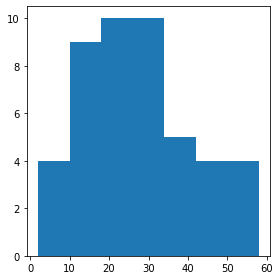

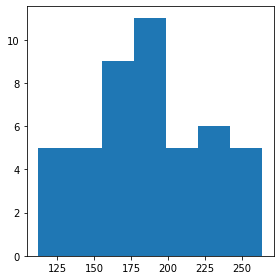

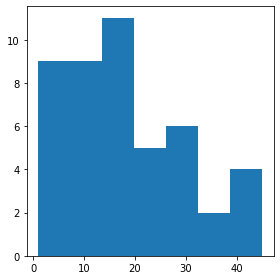

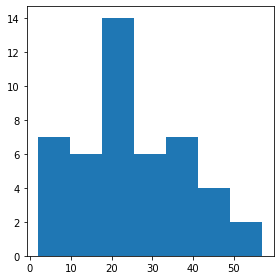

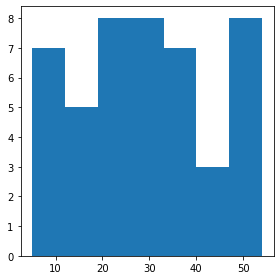

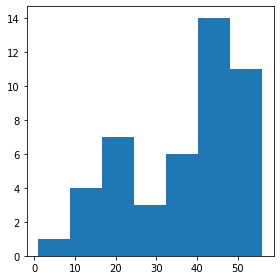

In [49]:
for i in range(6):
    fig, axs = plt.subplots(1, 1,
                            figsize =(4, 4),
                            tight_layout = True)

    axs.hist(df.iloc[:,i], bins = 7)

In [78]:
#df.to_csv('Volumes_6.csv', index = False)